# Introduction to BiSECT (Binary Sematic Extraction, Cleaning, and Transformation)

`BiSECT` was created to support vulnerability research, and provides a user-friendly and repeatable means to extract common features from compiled binary files and transform them into a format compatible with data mining and machine learning techniques. This Jupyter notebook provides an overview of the various functionality provided by `BiSECT`.

## Imports

If you want to follow along with the examples in this notebook, you'll need to import the following Python libraries:

In [98]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shutil, os
import csv
from ast import literal_eval
from IPython.display import Video
import re
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'
today = str(datetime.now().date())

## Data

Throughout this Notebook we'll be using the CB-Multios repository. You can download and compile the test cases yourself, or use the test cases we've precompiled for you. 

### Option 1: User download and compile

The repository can be downloaded directly from the `trailofbits` site [here](https://github.com/trailofbits/cb-multios) 

After extracting the archive, we compiled the test cases using an Ubuntu virtual machine (v. 20.04.2.0) and the following commands: 

`sudo apt install libc6-dev libc6-dev-i386 gcc-multilib g++-multilib clang cmake`

Followed by: 

`NO_PYTHON_I_KNOW_WHAT_I_AM_DOING_I_SWEAR=1 ./build.sh`

The build took about 20 minutes. Upon completion, you should have a nested /challenges/ directory that includes all of the compiled challenges

Now, we're only interested in the challenge binaries. To keep things simple when we use Ghidra in the next step we'll copy all of the executables to a single folder.

1. First use `find` to get a list of all executables in the directory:

Note: `/home/user/Desktop/cb-multios-master/build/challenges/` is the path the the `/challenges/` directory on your machine

In [ ]:
!find /home/user/Desktop/cb-multios-master/build/challenges/ -type f ! -name "*.*" -perm /u=x,g=x,o=x -printf "%p\n" > cb_multios_exes_paths.txt

2. Use `cb_multios_exes_paths.txt` to copy all of the executables to a new folder

In [ ]:
files = list(open('cb_multios_exes_paths.txt','r').read().splitlines())

for f in files:
    shutil.copy(f, 'cb_multios_binaries_originalvpatched')

### Option 2: Precompiled

For convenience, we've predownloaded and compiled the test cases for you. You can find them in the `/datasets` directory

In [20]:
!ls ~/Desktop/BiSECT-main/datasets/

cbmultios_original.tar.gz cbmultios_patched.tar.gz


Simply extract the archive to access the precompiled test cases

## Feature Extraction

Feature extraction is one of the things `BiSECT` does best. It should be pretty painless. 

### Using Ghidra Headless

Regardless of whether you want to extract features at the file level, function level, or both, each `*.py` script should be run using standard Ghidra headless syntax. You can read more about how these commands are to be structured on the official Ghidra.re site: [here](https://ghidra.re/ghidra_docs/analyzeHeadlessREADME.html)

In general, you'll run the scripts using something similar to the following: 

`yourpathto/GHIDRA/support/analyzeHeadless projectlocation/feature_extraction TestProject -import cb_multios_binaries_originalvpatched/cbmultios_original/ -analysisTimeoutPerFile num_seconds -deleteProject -scriptPath pathtoscripts/code -postScript pathtofeatureextractionscripts/ghidra_headless_feature_extraction.py -scriptlog pathtolog/my_log.log`

#### File Level

At the file level BiSECT extracts the following features and information from the sample directly (using Ghidra headless)

1. Sample path
2. Sample name
3. Total number of functions in the sample
4. List of all external functions, by name, in the sample
5. List of all internal functions, by name, in the sample
6. List of all opcodes in the sample

In [ ]:
def extract_data():
    path = currentProgram.getExecutablePath() # get the absolute path of the program currently being analyzed (i.e., the sample)
    name = currentProgram.getName() # the name of the sample
    listing = currentProgram.getListing()
    func_manager = currentProgram.getFunctionManager()
    no_subs = func_manager.getFunctionsNoStubs(True) # obj for all non-stub/non-empty functions in the sample

    function_count = func_manager.getFunctionCount() # number of functions in the sample
    external_fcns_obj = func_manager.getExternalFunctions() # obj for all external functions in the sample
    internal_fcns_obj = func_manager.getFunctions(True) # obj for all internal functions in the sample
    instructions_obj = listing.getInstructions(True) # obj for all instructions in the sample

    external_fcns = [fun.getName() for fun in external_fcns_obj] # a list of all external function names
    internal_fcns = [fun.getName() for fun in internal_fcns_obj] # a list of all internal function names
    instructions = [str(ins).split()[0] for ins in instructions_obj] # a list of all opcodes in binary

    cc = CyclomaticComplexity() # create instance of CyclomaticComplexity
        
final_list.append([path, function_count, external_fcns, internal_fcns, instructions, no_subs_list_func_cc])

#### Function Level

At the function level BiSECT extracts the following features from the sample directly (using Ghidra headless)

1. Cyclomatic Complexity
2. Function prototype
3. List of all instructions in the function
4. List of all mnemonics in the function

In [ ]:
for fun in no_subs: # do this for every real (i.e., non-stub function in the sample)
    complexity = cc.calculateCyclomaticComplexity(fun, monitor) # get the cyclomatic complexity for each true (to stub) fun in program
    prototype = fun.getSignature().getPrototypeString() # get the function prototype

    fun_addresses = fun.getBody() # get addr range for fcn
    code_units = listing.getCodeUnits(fun_addresses, True) # code units in fcn
    instr_in_fcn = listing.getInstructions(fun_addresses, True) # get the units in this fcn
    fun_inst = [code_unit.toString() for code_unit in code_units] # get all instructions within this function
    mnemonics = [str(ins).split()[0] for ins in instr_in_fcn] # get all mnemonics within this function

    no_subs_list_func_cc.append([name, fun.getName(), complexity, prototype, fun_inst, mnemonics]) # make a list of the function level features we want

### Using Raw Python

BiSECT also extracts a number of features using a few different Python scripts. 

The `sys_strings(file)` function is used to extract all strings in the sample, and the `calc_entropy(file)` function is used to calculate the Shannon entropy for each sample

In [ ]:
def sys_strings(file):
    '''
    Use subprocess to get strings
    '''
    strings = []
    p = subprocess.Popen(["strings", str(file)], stdout=subprocess.PIPE)
    out = p.stdout.readlines()
    out = [word[:-1] for word in out]
    out = set(out)
    strings.append(out)

    return strings

In [ ]:
def calc_entropy(file):
    with open(file, 'rb') as f:
        byteArr = list(f.read())
    fileSize = len(byteArr)

    # calculate the frequency of each byte value in the file
    freqList = []
    for b in range(256):
        ctr = 0
        for byte in byteArr:
            if byte == b:
                ctr += 1
        freqList.append(float(ctr) / fileSize)
    # Shannon entropy
    ent = 0.0
    for freq in freqList:
        if freq > 0:
            ent = ent + freq * math.log(freq, 2)
    ent = -ent
    return fileSize, ent

### Writing Custom Scripts

In addition to the scripts already provided by BiSECT, we encourage users to write their own custom scripts and extract features that may be meaningful for their use case. The basic requirement is that the final feature be formatted as a `.json`, `.csv`, or `.txt` that can be read in as a Pandas DataFrame. 

### Example: Feature extraction

In [ ]:
/Desktop/ghidra_9.0.2/support/analyzeHeadless
/Desktop/BiSECT-main/datasets/cb_multios_binaries_originalvpatched/features_original TestProject 
-import /Desktop/BiSECT-main/datasets/cb_multios_binaries_originalvpatched/cbmultios_original/
-analysisTimeoutPerFile 60 
-deleteProject 
-scriptPath /Desktop/BiSECT-main/feature_extractions/
-postScript /Desktop/BiSECT-main/feature_extractions/fcnlevelextractions_ghidra.py 
-scriptlog extraction_log.log

Using a MacBook Pro, it took about 13 minutes to extract the function level features for 281 test cases using Ghidra headless 

In [48]:
df = pd.read_csv('~/Desktop/BiSECT-main/feature_extractions/ghidra_function_level_2021-07-12.csv', header=None)

In [75]:
df.columns = ['file_name', 'function_name', 'cc', 'instructions']

In [50]:
df

,test_case,function_name,cc,instructions
0,FaceMag,_init,2,"[u'ENDBR32', u'PUSH EBX', u'SUB ESP,0x8', u'CA..."
1,FaceMag,FUN_0804a030,0,"[u'PUSH dword ptr [0x08054684]', u'JMP dword p..."
2,FaceMag,cgc_pow,1,[u'JMP dword ptr [0x0805468c]']
3,FaceMag,cgc__terminate,1,[u'JMP dword ptr [0x08054690]']
4,FaceMag,cgc_transmit,1,[u'JMP dword ptr [0x08054694]']
...,...,...,...,...
20641,yolodex,main,0,"[u'PUSH EBP', u'MOV EBP,ESP', u'SUB ESP,0x18',..."
20642,yolodex,__libc_csu_init,3,"[u'ENDBR32', u'PUSH EBP', u'CALL 0x0804c065', ..."
20643,yolodex,__libc_csu_fini,1,"[u'ENDBR32', u'RET']"
20644,yolodex,__x86.get_pc_thunk.bp,1,"[u'MOV EBP,dword ptr [ESP]', u'RET']"


# Data Cleaning & Transformation

After each feature has been extracted the data must be cleaned, consolidated, and transformed into a format that is compatible with machine learning algorithms and data mining techniques. The cleaning and transformation processes may involve the following steps: 

1. Missing Values: missing or incomplete values are removed, ignored, or replaced
2. Smoothing: noise and outliers removed from data using binning, regression, or other outlier analysis (e.g., clustering)
3. Numerics: non-numeric data is transformed into a numeric representation
4. Aggregation: summary and aggregation operations are applied to the data
5. Normalization/Scaling: features are normalized or scaled to fall within a smaller range (e.g., 0.0 to 1.0) 
6. Discretization: raw values of numeric data are binned by being transformed into interval ranges or conceptual labels
7. Feature Construction new features are constructed from existing features

Some steps, such as cleaning missing values or transforming non-numeric data into a numeric representation must be completed regardless of the features selected for analysis. Other steps, such as normalizing data or constructing new features may or may not be completed depending on the initial feature set and the user's goals. In the proceeding sections we highlight some of the functionality of `BiSECT`, and where appropriate, clarify any default values `BiSECT` users may want to modify depending on their specific usage scenario. 

## Data Cleaning

When using real-world data objects, such as binary files, some files may have missing, inconsistent, or incomplete attributes. Data cleaning typically involves two steps: dealing with missing values and smoothing outliers. 

Missing or incomplete values must first be identified, then either replaced, dropped, or ignored. It is important to note that missing values may not be the result of an error. For example, consider a feature, `strings`, that specifies the set of all unique strings in a binary sample. If a sample has no strings, this feature will appear to be missing for that data object. 

### Missing Values

When replacing missing values, the analyst can choose to ignore the missing values, perform a manual replacement, replace them with a global value, such as 'unknown' or 'null', or replace the values with some other statistically determined measurement, e.g., the measure of central tendency, or the most probable value for that feature. Each of these alternatives has drawbacks. For example, replacing missing values with another statistically determined value introduces bias into the dataset. This occurs because the replacement value may not be accurate. While manually replacing missing values may be accurate, it can also be time consuming. Replacing values with a global variable is simplistic; however, the analyst must be careful not perceive connections between samples with the same replaced value. 

For simplicity, `BiSECT` provides three options to the user: drop all data objects (i.e., samples) that contain a missing value for any feature, replace all missing values with a user provided replacement value (or a default of 0), and ignore the missing values (i.e., do nothing). The user should select the option that is best suited to their intended use case.

In [51]:
def missing_values(preference, df): 
    preferences = {0: 'drop', 1: 'fill', 2: 'ignore'}
    try: 
        preference = preferences[preference]
    except: 
        return "invalid preference provided"
    if preference == 0: 
        df = df.dropna()
    elif preference == 1: 
        df = df.fillna(0)
    elif preference == 2: 
        pass 
    return df

#### Example: Missing Values

We'll use `missing_values()` to drop any missing values

In [52]:
df = missing_values(0, df)

In [53]:
df

,test_case,function_name,cc,instructions
0,FaceMag,_init,2,"[u'ENDBR32', u'PUSH EBX', u'SUB ESP,0x8', u'CA..."
1,FaceMag,FUN_0804a030,0,"[u'PUSH dword ptr [0x08054684]', u'JMP dword p..."
2,FaceMag,cgc_pow,1,[u'JMP dword ptr [0x0805468c]']
3,FaceMag,cgc__terminate,1,[u'JMP dword ptr [0x08054690]']
4,FaceMag,cgc_transmit,1,[u'JMP dword ptr [0x08054694]']
...,...,...,...,...
20641,yolodex,main,0,"[u'PUSH EBP', u'MOV EBP,ESP', u'SUB ESP,0x18',..."
20642,yolodex,__libc_csu_init,3,"[u'ENDBR32', u'PUSH EBP', u'CALL 0x0804c065', ..."
20643,yolodex,__libc_csu_fini,1,"[u'ENDBR32', u'RET']"
20644,yolodex,__x86.get_pc_thunk.bp,1,"[u'MOV EBP,dword ptr [ESP]', u'RET']"


### Smoothing

After handling missing values, the next step is to smooth the dataset by reducing noise. Noise essentially equates to variance in a measured variable. Conventional methods to reduce noise include binning, regression, and outlier analysis. 

In binning, the objects are grouped into bins typically with neighboring objects, and smoothed by replacing each value with the mean, median, or boundary for that bin. When reducing noise using regression (e.g., via linear or multi-linear regression), the values are replaced by a line of best fit. Noise in a dataset can also be reduced using various forms of outlier analysis. Clustering, for example, can be used to quickly determine which data objects fall outside of the primary cluster or clusters. 

Since smoothing may or may not be appropriate, `BiSECT` does not perform any smoothing by default. Additionally, standard smoothing techniques are not applicable to features that are comprised of a set of text data (e.g., a set of unique strings in the sample). `BiSECT` provides an optional function, $smooth()$, that uses outlier analysis to perform smoothing. Users may apply $smooth()$ to individual features, such as cyclomatic complexity, as appropriate for their use case.

An example of smoothing is provided below.

#### Example: Smoothing cyclomatic complexity

Let's plot the `cc` feature, to get an idea of how the data is distributed.

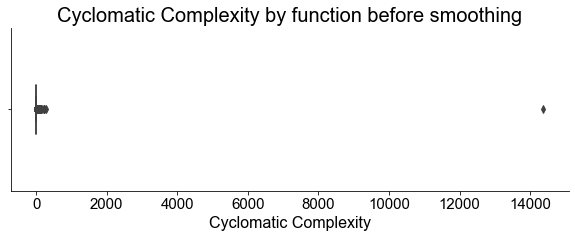

In [54]:
fig, ax = plt.subplots(figsize=(10, 3))
g = sns.boxplot(x=df["cc"],
                palette='mako', 
                ax=ax, 
                width=0.3)
g.set_title('Cyclomatic Complexity by function before smoothing', fontsize=20)
g.set_xlabel('Cyclomatic Complexity', fontsize=16)
g.tick_params(labelsize=15)
sns.despine()
sns.set_style("white")

g.figure.savefig("images/cc_presmooth.png")

It seems that we have some pretty significant outliers. So we'll apply the `smooth()` function, and only keep data within the 5-95th quantiles.

In [67]:
def smooth(col, df): 
    print('\nSmoothing: ' + col + ' (default to keep data between the 5-95th quantiles)')
    
    lower = np.percentile(df[col], 5) # lower bound
    upper = np.percentile(df[col], 95) # upper bound
    df = df[df[col].between(lower, upper)] # keeps data between lower and upper quantiles (bounds)
    
    print('\tSmoothing complete')
    return df

In [68]:
df = smooth('cc', df)


Smoothing: cc (default to keep data between the 5-95th quantiles)
	Smoothing complete


Now, let's replot the data. 

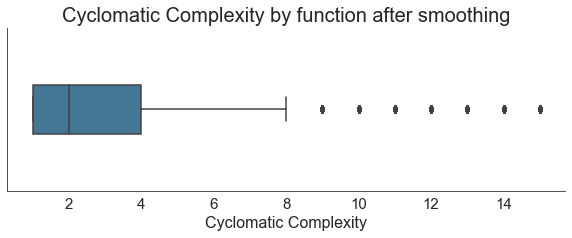

In [70]:
fig, ax = plt.subplots(figsize=(10, 3))
g = sns.boxplot(x=df['cc'],
                palette='mako', 
                ax=ax,
                width=0.3)
g.set_title('Cyclomatic Complexity by function after smoothing', fontsize=20)
g.set_xlabel('Cyclomatic Complexity', fontsize=16)
g.tick_params(labelsize=15)
sns.despine()
sns.set_style("white")

g.figure.savefig("images/cc_aftersmooth.png")

It seems that smoothing allowed us to reduce the noise in our dataset, which in turn creates a greater emphasis on the data within the primary quantiles.

## Data Transformation

After the dataset has been extracted and cleaned, the next steps involve performing one or more transformations of the data. `BiSECT` provides data aggregation, normalization, and feature construction transformations. 

### Aggregation

By default, `BiSECT` extracts the cyclomatic complexity for every function in every sample analyzed. This creates the feature called `cc`. Sometimes, users may be interested in aggregating the `cc` at a file level. This could help us answer questions such as, what is the `max cc` or `min cc` for every file analyzed? What is the `max cc` in all samples analyzed, or more insightful, what is the distribution of `max cc` across all samples analyzed, and does it differ for known vulnerable samples/functions?

In [76]:
def aggregation(df):
    print('Aggregating cyclomatic complexity data... ')
    df_mean = df.groupby('file_name', as_index=False)['cc'].mean()
    df_mean.columns = ['file_name', 'cc_mean']
    df_min = df.groupby('file_name', as_index=False)['cc'].min()
    df_min.columns = ['file_name', 'cc_min']
    df_max = df.groupby('file_name', as_index=False)['cc'].max()
    df_max.columns = ['file_name', 'cc_max']
    result = pd.merge(df_mean, df_min, on='file_name')
    df_aggregation = pd.merge(result, df_max, on='file_name')

    name = 'aggregated_cc_' + today + '.csv'
    print('\tSaving aggregated cyclomatic complexity data to: ' + name)
    df_aggregation.to_csv(name)

    return df_aggregation

In [80]:
df_aggregation = aggregation(df)

Aggregating cyclomatic complexity data... 
	Saving aggregated cyclomatic complexity data to: aggregated_cc_2021-07-14.csv


In [81]:
df_aggregation

,file_name,cc_mean,cc_min,cc_max
0,FaceMag,4.027273,1,15
1,Facilities_Access_Control_System,3.907216,1,15
2,FailAV,3.597122,1,15
3,FileSys,2.593458,1,14
4,Filesystem_Command_Shell,4.215517,1,15
...,...,...,...,...
212,tribute_3,2.303030,1,8
213,university_enrollment,3.462810,1,14
214,vFilter,3.550000,1,15
215,virtual_pet,2.468750,1,12


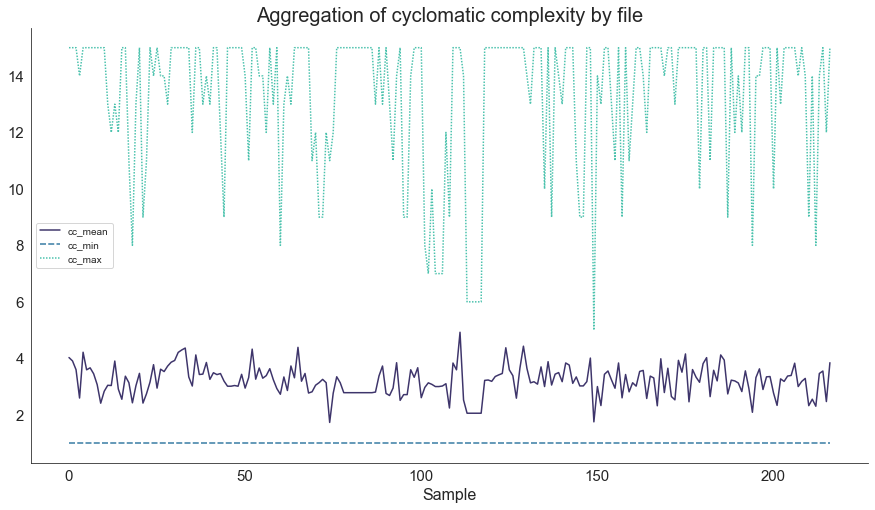

In [85]:
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(data=df_aggregation,
                palette='mako', 
                ax=ax)
g.set_title('Aggregation of cyclomatic complexity by file', fontsize=20)
g.set_xlabel('Sample', fontsize=16)
g.tick_params(labelsize=15)
sns.despine()
sns.set_style("white")

g.figure.savefig("images/aggregation_plot.png")

### Normalization

During normalization, features are scaled to fit within a standardized or smaller range. Normalizing the feature values forces all features to have an equal weight, and can prevent features with large ranges (e.g., file size) from outweighing features with small ranges (e.g., cyclomatic complexity). Treating all features equally, can also reduce the domain expertise required to distinguish the importance of one feature from another. Common normalization techniques include scaling (e.g., min-max, linear, or log scaling), clipping, and using a z-score.

`BiSECT` provides the user with the option of normalizing features using the function, $normalize()$. $normalize()$ applies min-max scaling using the following formula, 

\begin{equation}
x^{\prime}=\frac{x-\min (x)}{\max (x)-\min (x)}
\end{equation}

Where $x$ is the original value, and $x^{\prime}$ is the normalized value. The `normalize(df)` function can be used to optionally normalize any feature in the dataframe, or an entire dataframe. Like many of these functions, the `normalize(df)` function should be used as appropriate, depending on the users specific use case.

In [87]:
def normalize(df, col): 
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    #df = (df - df.min()) / (df.max() - df.min())
    return df

In [101]:
df = normalize(df, 'cc')

In [102]:
df

,file_name,function_name,cc,instructions,fuzzy_instr
0,FaceMag,_init,0.071429,"[ENDBR32, PUSH EBX, SUB ESP,0x8, CALL 0x0804a1...",endbr push ebx sub esp num call addr add ebx n...
2,FaceMag,cgc_pow,0.000000,[JMP dword ptr [0x0805468c]],jmp addr
3,FaceMag,cgc__terminate,0.000000,[JMP dword ptr [0x08054690]],jmp addr
4,FaceMag,cgc_transmit,0.000000,[JMP dword ptr [0x08054694]],jmp addr
5,FaceMag,cgc_allocate,0.000000,[JMP dword ptr [0x08054698]],jmp addr
...,...,...,...,...,...
20640,yolodex,cgc_inputLoop,0.500000,"[PUSH EBP, MOV EBP,ESP, SUB ESP,0x28, MOV EAX,...",push ebp mov ebp esp sub esp num mov eax esp l...
20642,yolodex,__libc_csu_init,0.142857,"[ENDBR32, PUSH EBP, CALL 0x0804c065, ADD EBP,0...",endbr push ebp call addr add ebp num push edi ...
20643,yolodex,__libc_csu_fini,0.000000,"[ENDBR32, RET]",endbr ret
20644,yolodex,__x86.get_pc_thunk.bp,0.000000,"[MOV EBP,dword ptr [ESP], RET]",mov ebp esp ret


### Feature Construction

During the feature construction phase, new features are created from existing features. The most noteworthy feature constructed by `BiSECT` (specifically for X86 binaries) is `fuzzy_instructions`. By default, `BiSECT` extracts the function sequence for each disassembled function in a binary sample. To prepare the instruction sequence to be compatible with machine learning algorithms, we perform a number of transformations on the original feature. 

First, we tokenize each instruction sequence into individual words, i.e., opcodes. Then, convert all characters to lowercase, and remove all punctuation and assembly size qualifiers such as `dword` and `byte`. Finally, a number of standardization's are performed. For example, each memory addresses is converted to `addr`, each conditional and non conditional jump is converted to `jump`, and all remaining numeric constants were converted to `num`. The resulting instruction set loosely resembles X86, and thus we refer to this feature as `fuzzy_instructions`. For example, the following transformation would occur: 

`"SUB RSP,0x10" ---> "sub rsp num"`

In [96]:
def clean_fuzzy(df):
    print('\nCreating Fuzzy Instruction Sequences... ')

    try: 
        df.instructions = df.instructions.apply(literal_eval) # only do this once
    except: 
        pass 
    
    df['fuzzy_instr'] = df['instructions'].apply(lambda x: " ".join(x)) #convert to space separated string
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: x.lower()) #make lower
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(',', ' ', x)) # replace commas with spaces
    words = ['qword', 'dword', 'genreplacement', 'word', 'ptr', 'dptr', 'byte', '[', ']', '-', '.', 'ds: ', 'es: ', '+', '-', '*']
    big_regex = re.compile('|'.join(map(re.escape, words)))
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: big_regex.sub('', x)) # remove stop words
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{6,}', 'addr', x)) # replace hex addr with addr
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{1,}', 'num', x)) # replace hex nums with num
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub('[^a-zA-Z ]', ' ', x)) # replace non alphanumerics with space
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: ' '.join(x.split())) # delete empty whitespace
    print('\tFuzzy Instructions complete')

    return df

In [99]:
df = clean_fuzzy(df)


Creating Fuzzy Instruction Sequences... 
	Fuzzy Instructions complete


In [100]:
df

,file_name,function_name,cc,instructions,fuzzy_instr
0,FaceMag,_init,0.071429,"[ENDBR32, PUSH EBX, SUB ESP,0x8, CALL 0x0804a1...",endbr push ebx sub esp num call addr add ebx n...
2,FaceMag,cgc_pow,0.000000,[JMP dword ptr [0x0805468c]],jmp addr
3,FaceMag,cgc__terminate,0.000000,[JMP dword ptr [0x08054690]],jmp addr
4,FaceMag,cgc_transmit,0.000000,[JMP dword ptr [0x08054694]],jmp addr
5,FaceMag,cgc_allocate,0.000000,[JMP dword ptr [0x08054698]],jmp addr
...,...,...,...,...,...
20640,yolodex,cgc_inputLoop,0.500000,"[PUSH EBP, MOV EBP,ESP, SUB ESP,0x28, MOV EAX,...",push ebp mov ebp esp sub esp num mov eax esp l...
20642,yolodex,__libc_csu_init,0.142857,"[ENDBR32, PUSH EBP, CALL 0x0804c065, ADD EBP,0...",endbr push ebp call addr add ebp num push edi ...
20643,yolodex,__libc_csu_fini,0.000000,"[ENDBR32, RET]",endbr ret
20644,yolodex,__x86.get_pc_thunk.bp,0.000000,"[MOV EBP,dword ptr [ESP], RET]",mov ebp esp ret


# Wrap up

If you made it this far you've seen most of the core functionality provided by `BiSECT`. As you have seen, the "CT" (cleaning and transformation) steps provided by `BiSECT` are really just a bunch of Python functions. We encourage you to play around with your data, add add whatever functionality to `BiSECT` that you want!

If you're interested in learning how to use features extracted by `BiSECT` with a couple of machine learning (NLP) scenarios check out the the Jupyter notebook titled, `BiSECT_vulnAnalysis.ipny`. 